In [1]:
#Cell 1: Importing libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import time

# Evaluation tools from sklearn
from sklearn.metrics import classification_report, balanced_accuracy_score

#Checking GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cpu


In [2]:
# Cell 2: Downloading the dataset and preparing the DataLoader

# Basic transformation: converting the image to a Tensor and applying simple normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    # אפשר גם להוסיף transforms.Normalize((0.1307,), (0.3081,)) אם רוצים
])

# הורדת הדאטה: אימון וטסט (MNIST כבר מפוצל ל-Train 60k ו-Test 10k)
train_val_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

# חלוקה ל-Train/Val: 60k -> 54k (Train) + 6k (Val)
train_size = 54000
val_size = 6000

indices = torch.randperm(len(train_val_dataset))
train_indices = indices[:train_size]
val_indices   = indices[train_size:train_size+val_size]

train_dataset = Subset(train_val_dataset, train_indices)
val_dataset   = Subset(train_val_dataset, val_indices)

# מגדירים DataLoader
batch_size_default = 50

train_loader = DataLoader(train_dataset, batch_size=batch_size_default, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size_default, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size_default, shuffle=False)

print(f"Train set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")


Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:00<00:00, 20.2MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 646kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.92MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.53MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Train set size: 54000
Validation set size: 6000
Test set size: 10000


In [3]:
# תא 3: פונקציות predict ו-score

def predict(model, data_loader, device=device):
    model.eval()
    all_preds = []
    with torch.no_grad():
        for images, _ in data_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
    return np.array(all_preds)

def score(model, data_loader, device=device):
    """
    מחשבת ומדפיסה Precision, Recall, F1, Accuracy, Balanced Accuracy
    לכל ספרה (0..9) על הדאטה ב-data_loader.
    """
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    print("Classification Report (precision/recall/f1/accuracy):")
    print(classification_report(all_labels, all_preds, digits=4))

    acc = np.mean(all_labels == all_preds)
    bal_acc = balanced_accuracy_score(all_labels, all_preds)

    print(f"Overall Accuracy: {acc:.4f}")
    print(f"Balanced Accuracy: {bal_acc:.4f}")
    return acc, bal_acc


In [4]:
# תא 4: הגדרת מודלים

# 1. Logistic Regression
class LogisticRegressionModel(nn.Module):
    def __init__(self):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(784, 10)  # 28*28 -> 10

    def forward(self, x):
        # קלט x בצורת (B, 1, 28, 28), נמיר ל- (B, 784)
        x = x.view(x.size(0), -1)
        out = self.linear(x)
        return out  # נקבל logits, נשתמש ב-CrossEntropyLoss

# 2. Fully Connected עם 2 שכבות חבויות (200, 200)
class FC2Model(nn.Module):
    def __init__(self):
        super(FC2Model, self).__init__()
        self.fc1 = nn.Linear(784, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 3. CNN עם שכבת קונבולוציה אחת
class CNN1Model(nn.Module):
    def __init__(self, p=32):  # out_channels=p
        super(CNN1Model, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=p, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # לאחר הקונבולוציה וה-Pool, גודל המפה = 14x14 עם p channels
        # כלומר סה"כ פיצ'רים = p * 14 * 14
        self.fc = nn.Linear(p * 14 * 14, 1024)
        self.out = nn.Linear(1024, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)         # גודל יוצא: p x 14 x 14
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc(x))
        x = self.out(x)
        return x

# 4. CNN עם 2 שכבות קונבולוציה
class CNN2Model(nn.Module):
    def __init__(self, p1=32, p2=64):
        super(CNN2Model, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=p1, kernel_size=5, stride=1, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=p1, out_channels=p2, kernel_size=5, stride=1, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # לאחר 2 pool-ים: 28x28 -> 14x14 -> 7x7 עם p2 channels
        self.fc = nn.Linear(p2 * 7 * 7, 1024)
        self.out = nn.Linear(1024, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc(x))
        x = self.out(x)
        return x

# 5. CNN עם 2 שכבות קונבולוציה + Dropout
class CNN2DropoutModel(nn.Module):
    def __init__(self, p1=32, p2=64, dropout_p=0.5):
        super(CNN2DropoutModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=p1, kernel_size=5, stride=1, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=p1, out_channels=p2, kernel_size=5, stride=1, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc = nn.Linear(p2 * 7 * 7, 1024)
        self.dropout = nn.Dropout(dropout_p)
        self.out = nn.Linear(1024, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc(x))
        x = self.dropout(x)
        x = self.out(x)
        return x


In [5]:
# תא 5: פונקציה לספירת פרמטרים
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [6]:
# תא 6: פונקציית אימון כללית
def train_model(model, train_loader, val_loader=None,
                num_iterations=13000,
                lr=1e-3,
                device=device):
    """
    מאמן מודל למשך num_iterations איטרציות.
    בכל איטרציה לוקח מיני-באץ' מה-train_loader (Iter).
    """
    model.to(device)
    model.train()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # יצירת איטרטור אינסופי מעל train_loader
    train_iter = iter(train_loader)
    total_batches = 0

    start_time = time.time()

    for i in range(num_iterations):
        try:
            images, labels = next(train_iter)
        except StopIteration:
            # אם נגמר - נאתחל מחדש
            train_iter = iter(train_loader)
            images, labels = next(train_iter)

        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_batches += 1

        # אפשר למשל להדגים הדפסת סטטוס מדי כמה מאות איטרציות
        if (i+1) % 2000 == 0:
            print(f"Iteration {i+1}/{num_iterations}, Loss: {loss.item():.4f}")

    end_time = time.time()
    train_time = end_time - start_time
    print(f"Finished training in {train_time:.2f} seconds, total {num_iterations} iterations.")

    return train_time


In [9]:
# תא 7: אימון ו-score לכל הארכיטקטורות

num_iterations = 13000  # נדרש במטלה
lr = 1e-3

# 1. Logistic Regression
model_logreg = LogisticRegressionModel()
print("=== Logistic Regression ===")
print("Number of parameters:", count_parameters(model_logreg))
t_train = train_model(model_logreg, train_loader, val_loader, num_iterations, lr)
print("Train set scores:")
score(model_logreg, train_loader)
print("Validation set scores:")
score(model_logreg, val_loader)
print("Test set scores:")
score(model_logreg, test_loader)
print("Training time:", t_train, "seconds")
print("-"*50)

# 2. Fully Connected 2 layers
model_fc2 = FC2Model()
print("=== FC2 (2 hidden layers) ===")
print("Number of parameters:", count_parameters(model_fc2))
t_train = train_model(model_fc2, train_loader, val_loader, num_iterations, lr)
print("Train set scores:")
score(model_fc2, train_loader)
print("Validation set scores:")
score(model_fc2, val_loader)
print("Test set scores:")
score(model_fc2, test_loader)
print("Training time:", t_train, "seconds")
print("-"*50)

# 3. CNN עם שכבת קונבולוציה אחת
model_cnn1 = CNN1Model(p=32)
print("=== CNN1 (Single Conv) ===")
print("Number of parameters:", count_parameters(model_cnn1))
t_train = train_model(model_cnn1, train_loader, val_loader, num_iterations, lr)
print("Train set scores:")
score(model_cnn1, train_loader)
print("Validation set scores:")
score(model_cnn1, val_loader)
print("Test set scores:")
score(model_cnn1, test_loader)
print("Training time:", t_train, "seconds")
print("-"*50)

# 4. CNN עם 2 שכבות קונבולוציה
model_cnn2 = CNN2Model(p1=32, p2=64)
print("=== CNN2 (Two Conv) ===")
print("Number of parameters:", count_parameters(model_cnn2))
t_train = train_model(model_cnn2, train_loader, val_loader, num_iterations, lr)
print("Train set scores:")
score(model_cnn2, train_loader)
print("Validation set scores:")
score(model_cnn2, val_loader)
print("Test set scores:")
score(model_cnn2, test_loader)
print("Training time:", t_train, "seconds")
print("-"*50)

# 5. CNN עם 2 שכבות קונבולוציה + Dropout(0.5)
model_cnn2drop = CNN2DropoutModel(p1=32, p2=64, dropout_p=0.5)
print("=== CNN2 + Dropout(0.5) ===")
print("Number of parameters:", count_parameters(model_cnn2drop))
t_train = train_model(model_cnn2drop, train_loader, val_loader, num_iterations, lr)
print("Train set scores:")
score(model_cnn2drop, train_loader)
print("Validation set scores:")
score(model_cnn2drop, val_loader)
print("Test set scores:")
score(model_cnn2drop, test_loader)
print("Training time:", t_train, "seconds")
print("-"*50)


=== Logistic Regression ===
Number of parameters: 7850
Iteration 2000/13000, Loss: 0.1980
Iteration 4000/13000, Loss: 0.3985
Iteration 6000/13000, Loss: 0.3320
Iteration 8000/13000, Loss: 0.1959
Iteration 10000/13000, Loss: 0.5506
Iteration 12000/13000, Loss: 0.1024
Finished training in 99.90 seconds, total 13000 iterations.
Train set scores:
Classification Report (precision/recall/f1/accuracy):
              precision    recall  f1-score   support

           0     0.9686    0.9731    0.9708      5318
           1     0.9571    0.9767    0.9668      6082
           2     0.9392    0.9100    0.9244      5380
           3     0.9128    0.9156    0.9142      5489
           4     0.9406    0.9345    0.9375      5266
           5     0.9196    0.8811    0.8999      4868
           6     0.9496    0.9676    0.9585      5314
           7     0.9544    0.9365    0.9454      5626
           8     0.8925    0.9119    0.9021      5281
           9     0.9023    0.9237    0.9129      5376

    a

In [10]:
# תא 8: השוואת batch_size=50 לעומת batch_size=100 בארכיטקטורה 5

def train_and_track_val_acc(model_class,
                            train_dataset, val_loader,
                            batch_size,
                            target_acc=0.99,
                            check_interval=200,
                            max_iterations=13000,
                            lr=1e-3,
                            device=device):
    """
    מאמן מודל מסוג model_class (למשל CNN2DropoutModel)
    עם train_dataset ו-val_loader, בגודל מיני-באץ' = batch_size.
    בכל check_interval איטרציות נבדוק Accuracy על Val;
    אם הגענו ל-target_acc, נעצור ונדפיס זמן/איטרציות.
    נחזיר את מספר האיטרציות והזמן שלקח להגיע ל-accuracy הזה (או None אם לא הגענו).
    """
    # הכנת DataLoader עבור הטראין עם batch_size הנדרש
    train_loader_local = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model = model_class().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_iter = iter(train_loader_local)

    start_time = time.time()
    reached_target = False
    reached_iter = None
    for i in range(max_iterations):
        try:
            images, labels = next(train_iter)
        except StopIteration:
            train_iter = iter(train_loader_local)
            images, labels = next(train_iter)

        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if (i+1) % check_interval == 0:
            # בדיקת accuracy על ה-Validation
            all_preds = []
            all_labels = []
            model.eval()
            with torch.no_grad():
                for vimages, vlabels in val_loader:
                    vimages = vimages.to(device)
                    vlabels = vlabels.to(device)
                    voutputs = model(vimages)
                    _, vpred = torch.max(voutputs, 1)
                    all_preds.extend(vpred.cpu().numpy())
                    all_labels.extend(vlabels.cpu().numpy())
            model.train()

            all_preds = np.array(all_preds)
            all_labels = np.array(all_labels)
            acc = np.mean(all_preds == all_labels)

            if acc >= target_acc and not reached_target:
                reached_target = True
                reached_iter = i+1
                break

    end_time = time.time()
    elapsed = end_time - start_time

    return reached_target, reached_iter, elapsed

# הרצה בשני גדלי באץ'
for bs in [50, 100]:
    print(f"=== Training CNN2Dropout with batch_size={bs} ===")
    reached, iters, ttime = train_and_track_val_acc(
        CNN2DropoutModel,
        train_dataset,
        val_loader,
        batch_size=bs,
        target_acc=0.99,
        check_interval=200,
        max_iterations=13000,
        lr=1e-3,
        device=device
    )
    if reached:
        print(f"Reached 0.99 accuracy on Validation after {iters} iterations, in {ttime:.2f} seconds.")
    else:
        print(f"Did NOT reach 0.99 accuracy by {13000} iterations. Final time {ttime:.2f} sec.")
    print("-"*50)


=== Training CNN2Dropout with batch_size=50 ===
Reached 0.99 accuracy on Validation after 4400 iterations, in 858.38 seconds.
--------------------------------------------------
=== Training CNN2Dropout with batch_size=100 ===
Reached 0.99 accuracy on Validation after 3800 iterations, in 1145.84 seconds.
--------------------------------------------------


In [11]:
# תא 9: פונקציה להצגת הפילטרים
def show_conv_filters(model, layer_name='conv1'):
    """
    מציגה גריד של משקולות הפילטר בשכבת Conv בשם layer_name.
    נניח שהפילטרים in_channels=1 (כמו MNIST), כך שכל פילטר הוא 2D.
    אם יש יותר מ-in_channels=1, אפשר לנסות להציג כל channel בנפרד.
    """
    # נניח שהשכבה היא nn.Conv2d
    layer = getattr(model, layer_name, None)
    if layer is None:
        print(f"No layer named {layer_name} found in model.")
        return

    # משקולות בצורה (out_channels, in_channels, kernel_h, kernel_w)
    filters = layer.weight.data.clone().cpu().numpy()
    out_ch, in_ch, k_h, k_w = filters.shape

    # אם in_ch>1, צריך להחליט איך מציגים. כאן נניח in_ch=1 לצורך MNIST.
    fig, axes = plt.subplots(1, out_ch, figsize=(out_ch*2, 2))
    for i in range(out_ch):
        ax = axes[i]
        f = filters[i, 0, :, :]  # לוקחים את הערוץ הראשון בלבד
        ax.imshow(f, cmap='gray')
        ax.axis('off')
    plt.show()

# דוגמה לשימוש (נניח שנבחר המודל שהשיג Balanced Accuracy הכי גבוה, כאן נניח model_cnn2drop):
# show_conv_filters(model_cnn2drop, 'conv1')
# show_conv_filters(model_cnn2drop, 'conv2')


In [12]:
# תא 10: הצגת Feature Maps

def visualize_feature_maps(model, images, layer_num=1, channel_num=0):
    """
    מציגה את תמונת המקור ואת המפה הקונבולוציונית לפני ואחרי ReLU עבור שכבה מס' layer_num במודל.
    עבור מודל עם 2 שכבות, layer_num=1 או 2.
    channel_num=0 כברירת מחדל.

    images: batch of images (tensor shape [B,1,28,28]) או אפילו תמונה בודדת עם batch_size=1.
    """
    model.eval()

    with torch.no_grad():
        x = images.clone().to(device)

        # conv1 + relu + pool
        conv1_out = model.conv1(x)
        conv1_out_before_relu = conv1_out.clone()
        conv1_out_after_relu  = F.relu(conv1_out)

        # אם יש שכבה ראשונה בלבד, נבדוק layer_num=1
        if layer_num == 1:
            # מציגים
            # מקור
            original_image = x[0,0,:,:].cpu().numpy()
            plt.figure(figsize=(10,3))

            # הצגה של התמונה המקורית
            plt.subplot(1,3,1)
            plt.title("Original")
            plt.imshow(original_image, cmap='gray')
            plt.axis('off')

            # לפני ReLU
            feature_map_before = conv1_out_before_relu[0, channel_num, :, :].cpu().numpy()
            plt.subplot(1,3,2)
            plt.title("Conv1 (before ReLU)")
            plt.imshow(feature_map_before, cmap='gray')
            plt.axis('off')

            # אחרי ReLU
            feature_map_after = conv1_out_after_relu[0, channel_num, :, :].cpu().numpy()
            plt.subplot(1,3,3)
            plt.title("Conv1 (after ReLU)")
            plt.imshow(feature_map_after, cmap='gray')
            plt.axis('off')

            plt.show()
            return

        # המשך למודל דו-שכבתי
        pool1_out = model.pool1(conv1_out_after_relu)

        conv2_out = model.conv2(pool1_out)
        conv2_out_before_relu = conv2_out.clone()
        conv2_out_after_relu  = F.relu(conv2_out)

        if layer_num == 2:
            # מציגים את אותה לוגיקה אבל עבור conv2
            original_image = x[0,0,:,:].cpu().numpy()
            plt.figure(figsize=(10,5))

            plt.subplot(1,3,1)
            plt.title("Original")
            plt.imshow(original_image, cmap='gray')
            plt.axis('off')

            feature_map_before = conv2_out_before_relu[0, channel_num, :, :].cpu().numpy()
            plt.subplot(1,3,2)
            plt.title("Conv2 (before ReLU)")
            plt.imshow(feature_map_before, cmap='gray')
            plt.axis('off')

            feature_map_after = conv2_out_after_relu[0, channel_num, :, :].cpu().numpy()
            plt.subplot(1,3,3)
            plt.title("Conv2 (after ReLU)")
            plt.imshow(feature_map_after, cmap='gray')
            plt.axis('off')

            plt.show()
        else:
            print("layer_num צריך להיות 1 או 2 במודל זה.")

# דוגמה לשימוש:
# בוחרים 4 תמונות מ-Validation או Test


Example index=1255, true label=6


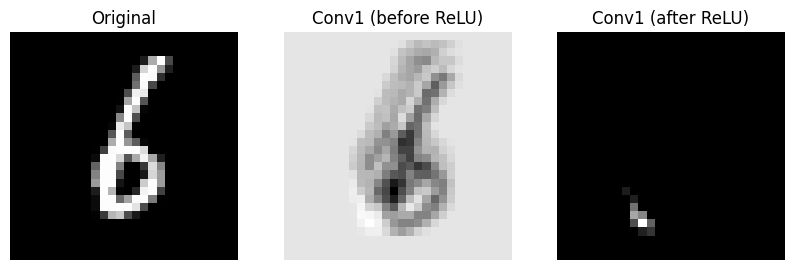

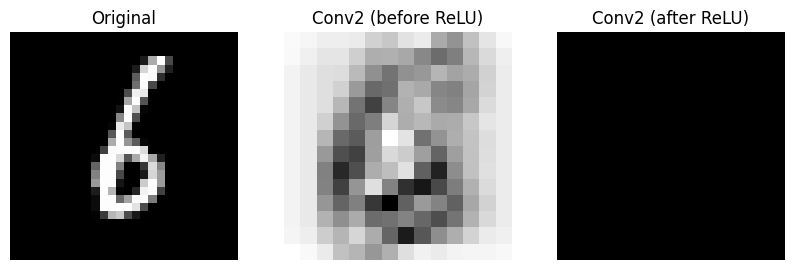

Example index=3030, true label=9


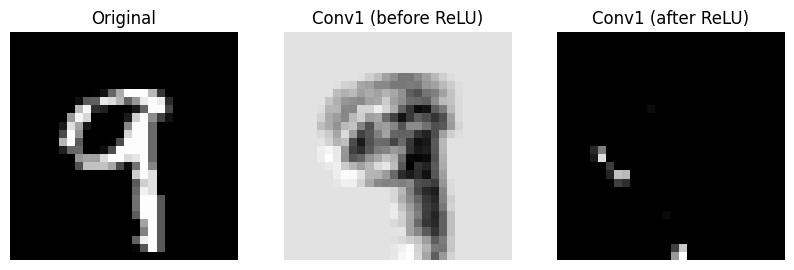

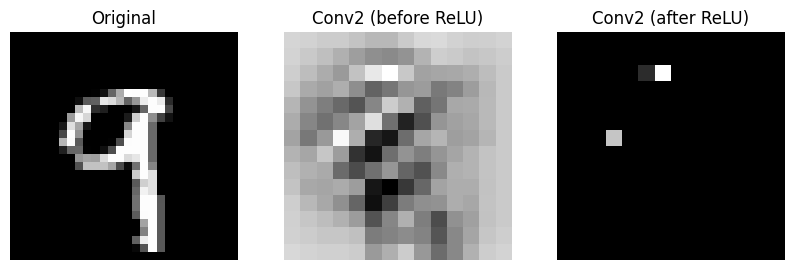

Example index=3593, true label=5


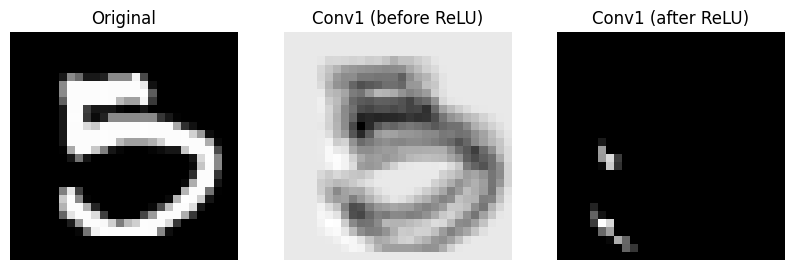

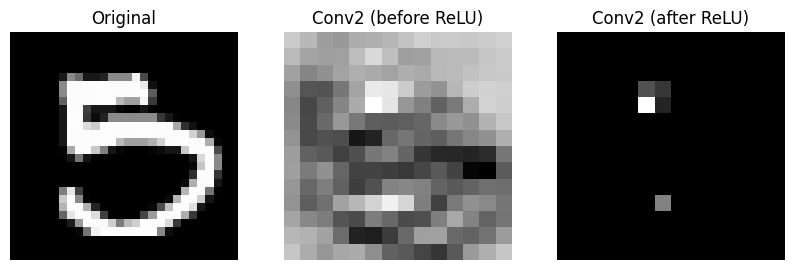

Example index=2811, true label=2


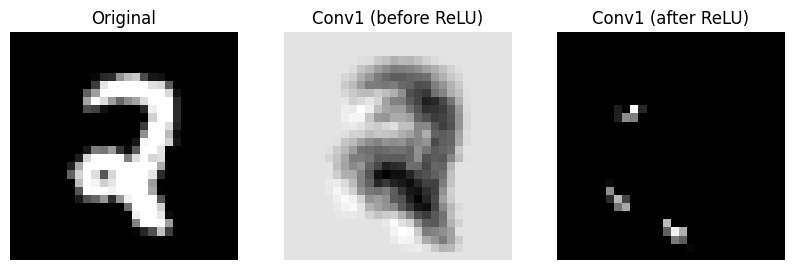

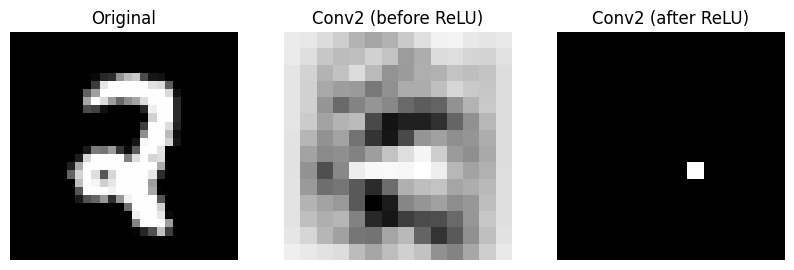

In [13]:
# תא 11: הדגמת ויזואליזציה על 4 תמונות

# נניח שנרצה להדגים על המודל CNN2DropoutModel שאומן (model_cnn2drop)
model_cnn2drop.eval()

# בוחרים 4 דוגמאות מתוך ה-Validation
some_indices = np.random.choice(len(val_dataset), size=4, replace=False)

for idx in some_indices:
    image, label = val_dataset[idx]
    image_batch = image.unsqueeze(0)  # [1,1,28,28]

    # הדפסת כותרת
    print(f"Example index={idx}, true label={label}")

    # מציגים Conv1
    visualize_feature_maps(model_cnn2drop, image_batch, layer_num=1, channel_num=0)
    # מציגים Conv2
    visualize_feature_maps(model_cnn2drop, image_batch, layer_num=2, channel_num=0)

    print("="*40)
